# Perhitungan Skor RNN-IDS

## Import All Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math

## Load All the Data

In [2]:
df_pred = pd.read_csv('/home/apta/neuralnetwork-AD/rnn-apta/results/vector/Combine_Control_Tuesday-WorkingHours_training_80/result-lstm-tcp80-hl2-seq5-do0.2-oov1500-Wednesday-WorkingHours_testing_80.csv', 
                      names=['id', 'binary_error', 'b_mean', 'b_iqr', 'b_zscore', 'floatin_error', 'f_mean', 'f_iqr', 'f_zscore'])

df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Wednesday-workingHours.pcap_ISCX.csv', 
                       encoding='ISO-8859-1')

In [3]:
df_pred.head()

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore
0,192.168.10.15-49451-13.107.4.50-80-tcp,0.085714,0,0,1,30255.070968,0,0,0
1,192.168.10.16-37380-91.189.88.161-80-tcp,0.064103,0,0,1,27761.013245,0,0,0
2,192.168.10.15-49451-13.107.4.50-80-tcp,0.086344,0,0,1,27263.895844,0,0,0
3,192.168.10.14-49463-23.194.182.93-80-tcp,0.296970,0,0,0,87866.456250,0,1,1
4,192.168.10.14-49467-165.254.0.90-80-tcp,0.095973,0,0,1,18746.609428,0,0,0


In [4]:
df_truth.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.14-209.48.71.168-49459-80-6,192.168.10.14,49459,209.48.71.168,80,6,5/7/2017 8:42,38308,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.3-192.168.10.17-389-49453-6,192.168.10.17,49453,192.168.10.3,389,6,5/7/2017 8:42,479,11,5,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.3-192.168.10.17-88-46124-6,192.168.10.17,46124,192.168.10.3,88,6,5/7/2017 8:42,1095,10,6,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.3-192.168.10.17-389-49454-6,192.168.10.17,49454,192.168.10.3,389,6,5/7/2017 8:42,15206,17,12,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.3-192.168.10.17-88-46126-6,192.168.10.17,46126,192.168.10.3,88,6,5/7/2017 8:42,1092,9,6,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


## Exploratory Data Analysis

In [5]:
df_pred[['b_iqr']].value_counts()

b_iqr
0        197573
Name: count, dtype: int64

In [6]:
df_pred[['b_zscore']].value_counts()

b_zscore
1           168532
0            29041
Name: count, dtype: int64

In [7]:
df_truth.isnull().sum()

Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
Idle Mean            0
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Label               0
Length: 85, dtype: int64

## Data Pre-Processing

### Convert the type of the data

In [8]:
df_truth.columns = df_truth.columns.str.strip()  # remove leading/trailing spaces
df_truth.columns = df_truth.columns.str.replace(' ', '_')  # optional: make them easier to type

df_truth['Source_Port'] = pd.to_numeric(df_truth['Source_Port'], errors='coerce')
df_truth['Destination_Port'] = pd.to_numeric(df_truth['Destination_Port'], errors='coerce')

# Optionally: drop rows with NaN in these columns
df_truth.dropna(subset=['Source_Port', 'Destination_Port'], inplace=True)

# Filter to only include rows where either port is 80
df_truth = df_truth[(df_truth['Source_Port'] == 80) | (df_truth['Destination_Port'] == 80)]

# Now you can safely convert to int
df_truth['Source_Port'] = df_truth['Source_Port'].astype(int)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(int)


df_truth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 325628 entries, 0 to 692697
Data columns (total 85 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow_ID                      325628 non-null  object 
 1   Source_IP                    325628 non-null  object 
 2   Source_Port                  325628 non-null  int64  
 3   Destination_IP               325628 non-null  object 
 4   Destination_Port             325628 non-null  int64  
 5   Protocol                     325628 non-null  int64  
 6   Timestamp                    325628 non-null  object 
 7   Flow_Duration                325628 non-null  int64  
 8   Total_Fwd_Packets            325628 non-null  int64  
 9   Total_Backward_Packets       325628 non-null  int64  
 10  Total_Length_of_Fwd_Packets  325628 non-null  int64  
 11  Total_Length_of_Bwd_Packets  325628 non-null  float64
 12  Fwd_Packet_Length_Max        325628 non-null  int64  
 13  Fwd_

In [9]:
df_truth['Label'].head()

0     BENIGN
7     BENIGN
19    BENIGN
54    BENIGN
56    BENIGN
Name: Label, dtype: object

In [10]:
df_truth['Source_Port'] = df_truth['Source_Port'].astype(str)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(str)

df_truth['Protocol'] = pd.to_numeric(df_truth['Protocol'], errors='coerce')  
df_truth.dropna(subset=['Protocol'], inplace=True)                      
df_truth['Protocol'] = df_truth['Protocol'].astype(int).astype(str)         

protocol_map = {
    '6': 'tcp',
    '17': 'udp',
    '1': 'icmp',
    '0': 'other'  # fallback or unknown
}

# Convert 'Protocol' number to string using the mapping
def map_protocol(protocol):
    return protocol_map.get(protocol, 'other')

# Apply the conversion for 'Protocol' and concatenate the 'id'
df_truth['id'] = df_truth[['Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol']]\
    .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)

/tmp/ipykernel_363710/691346611.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)


## Making Predictions

In [11]:
df_pred["id"]

0           192.168.10.15-49451-13.107.4.50-80-tcp
1         192.168.10.16-37380-91.189.88.161-80-tcp
2           192.168.10.15-49451-13.107.4.50-80-tcp
3         192.168.10.14-49463-23.194.182.93-80-tcp
4          192.168.10.14-49467-165.254.0.90-80-tcp
                            ...                   
197568    192.168.10.16-33590-199.59.88.242-80-tcp
197569    192.168.10.16-33594-199.59.88.242-80-tcp
197570    192.168.10.16-33588-199.59.88.242-80-tcp
197571    192.168.10.16-33596-199.59.88.242-80-tcp
197572    192.168.10.16-49086-54.192.36.242-80-tcp
Name: id, Length: 197573, dtype: object

In [12]:
df_truth["id"]

0         192.168.10.14-49459-209.48.71.168-80-tcp
7         192.168.10.16-37380-91.189.88.161-80-tcp
19         23.61.187.27-80-192.168.10.15-49441-tcp
54           192.168.10.15-49440-23.15.4.24-80-tcp
56        192.168.10.15-49447-165.254.0.106-80-tcp
                            ...                   
692681       172.16.0.1-45758-192.168.10.50-80-tcp
692682      172.217.10.6-80-192.168.10.8-54901-tcp
692694      72.21.91.29-80-192.168.10.16-35450-tcp
692696       172.16.0.1-45756-192.168.10.50-80-tcp
692697    113.29.190.10-80-192.168.10.19-49346-tcp
Name: id, Length: 325628, dtype: object

In [13]:
# Using boolean indexing to filter by the specific ID
count = df_truth[df_truth["id"] == "192.168.10.15-49451-13.107.4.50-80-tcp"].shape[0]

print(count)


1


In [14]:
# Convert 'Label' column to numeric: BENIGN -> 0, other -> 1
df_truth['Label'] = df_truth['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [15]:
# df_pred["Label"] = np.where(df_pred["id"].isin(df_truth["id"]), 1, 0)

df_pred = df_pred.merge(df_truth[['id', 'Label']], on='id', how='left')
df_pred = df_pred.dropna(subset=['Label'])

In [16]:
df_pred[df_pred['Label']==1]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
5673,172.16.0.1-53688-192.168.10.50-80-tcp,0.088106,0,0,1,28777.342342,0,0,0,1
5674,172.16.0.1-53688-192.168.10.50-80-tcp,0.088106,0,0,1,28777.342342,0,0,0,1
5675,172.16.0.1-53688-192.168.10.50-80-tcp,0.088106,0,0,1,28777.342342,0,0,0,1
5676,172.16.0.1-53688-192.168.10.50-80-tcp,0.088106,0,0,1,28777.342342,0,0,0,1
5677,172.16.0.1-53688-192.168.10.50-80-tcp,0.088106,0,0,1,28777.342342,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
3041051,172.16.0.1-42108-192.168.10.50-80-tcp,0.116935,0,0,1,34741.050916,0,0,0,1
3053152,172.16.0.1-49631-192.168.10.50-80-tcp,0.044734,0,0,1,11716.651685,0,0,0,1
3053153,172.16.0.1-49631-192.168.10.50-80-tcp,0.044734,0,0,1,11716.651685,0,0,0,1
3053157,172.16.0.1-49633-192.168.10.50-80-tcp,0.045205,0,0,1,14313.582108,0,0,0,1


In [17]:
df_pred[df_pred['Label']==0]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.15-49451-13.107.4.50-80-tcp,0.085714,0,0,1,30255.070968,0,0,0,0
1,192.168.10.16-37380-91.189.88.161-80-tcp,0.064103,0,0,1,27761.013245,0,0,0,0
2,192.168.10.15-49451-13.107.4.50-80-tcp,0.086344,0,0,1,27263.895844,0,0,0,0
3,192.168.10.14-49463-23.194.182.93-80-tcp,0.296970,0,0,0,87866.456250,0,1,1,0
4,192.168.10.14-49467-165.254.0.90-80-tcp,0.095973,0,0,1,18746.609428,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3088286,192.168.10.16-33590-199.59.88.242-80-tcp,0.041256,0,0,1,29562.754955,0,0,0,0
3088287,192.168.10.16-33594-199.59.88.242-80-tcp,0.040143,0,0,1,27491.162186,0,0,0,0
3088288,192.168.10.16-33588-199.59.88.242-80-tcp,0.049351,0,0,1,35575.321739,0,0,0,0
3088289,192.168.10.16-33596-199.59.88.242-80-tcp,0.052721,0,0,1,41740.116638,0,0,0,0


In [18]:
df_pred

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.15-49451-13.107.4.50-80-tcp,0.085714,0,0,1,30255.070968,0,0,0,0
1,192.168.10.16-37380-91.189.88.161-80-tcp,0.064103,0,0,1,27761.013245,0,0,0,0
2,192.168.10.15-49451-13.107.4.50-80-tcp,0.086344,0,0,1,27263.895844,0,0,0,0
3,192.168.10.14-49463-23.194.182.93-80-tcp,0.296970,0,0,0,87866.456250,0,1,1,0
4,192.168.10.14-49467-165.254.0.90-80-tcp,0.095973,0,0,1,18746.609428,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3088286,192.168.10.16-33590-199.59.88.242-80-tcp,0.041256,0,0,1,29562.754955,0,0,0,0
3088287,192.168.10.16-33594-199.59.88.242-80-tcp,0.040143,0,0,1,27491.162186,0,0,0,0
3088288,192.168.10.16-33588-199.59.88.242-80-tcp,0.049351,0,0,1,35575.321739,0,0,0,0
3088289,192.168.10.16-33596-199.59.88.242-80-tcp,0.052721,0,0,1,41740.116638,0,0,0,0


In [19]:
df_pred[['Label']].value_counts()

Label
1        3015147
0          73144
Name: count, dtype: int64

In [20]:
import os
# Define the directory path
dir_path = '../mcnemar/ftp'

# Check if the directory exists, and if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

df_temp = df_pred[['id', 'b_mean','b_iqr', 'b_zscore', 'f_zscore', 'f_mean','f_iqr' ]]
df_temp.to_csv(os.path.join(dir_path, 'pred_0.0.csv'))

## Calculating Score

In [21]:
threshold = ['b_mean', 'b_iqr', 'b_zscore']
threshold_2 = ['f_mean', 'f_iqr', 'f_zscore']

methods = ['binary', 'floating']

In [22]:
df_pred[['b_zscore']]

,b_zscore
0,1
1,1
2,1
3,0
4,1
...,...
3088286,1
3088287,1
3088288,1
3088289,1


### Detection Rate

In [23]:
from sklearn.metrics import recall_score

score = dict()
score['Detection Rate'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = recall_score(df_pred['Label'], df_pred[i].astype(int))
            score['Detection Rate'][i] = acc
            print(f'Recall-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = recall_score(df_pred['Label'], df_pred[i].astype(int))
            score['Detection Rate'][i] = acc
            print(f'Recall-Floating-{i}: {acc}')  

Recall-Binary-b_mean: 0.0
Recall-Binary-b_iqr: 0.0
Recall-Binary-b_zscore: 0.8275092391846899
Recall-Floating-f_mean: 0.0
Recall-Floating-f_iqr: 0.0018284348988623108
Recall-Floating-f_zscore: 0.0


### Confussion Matrix

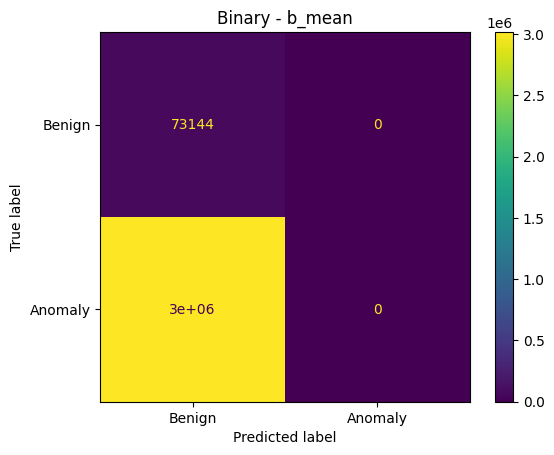

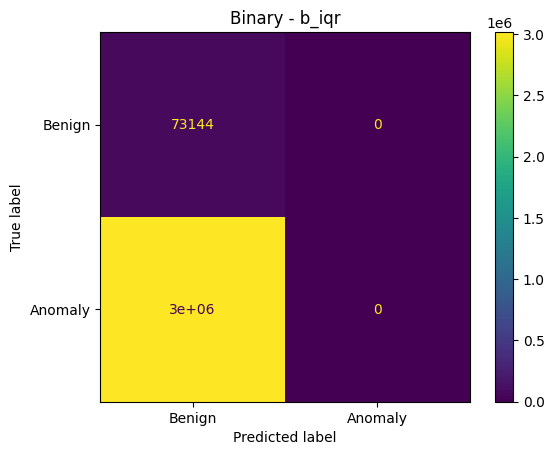

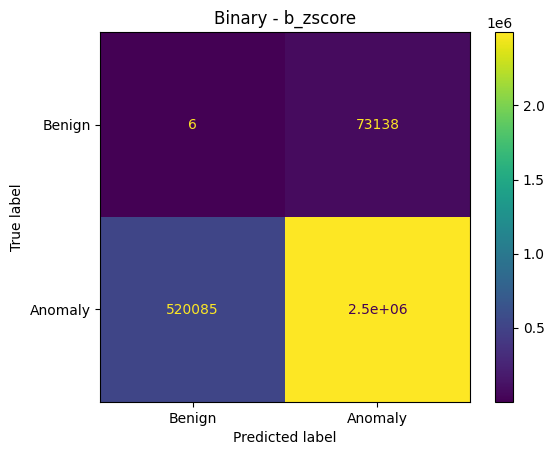

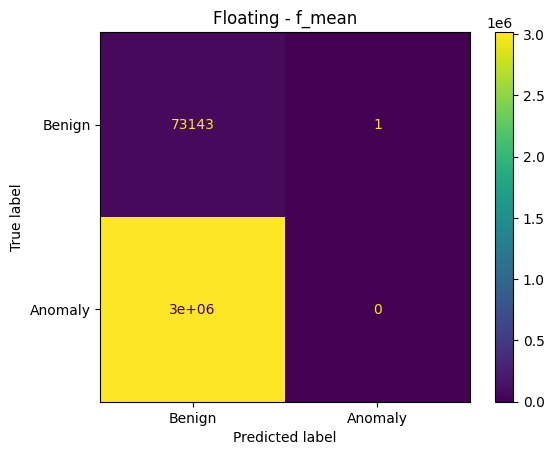

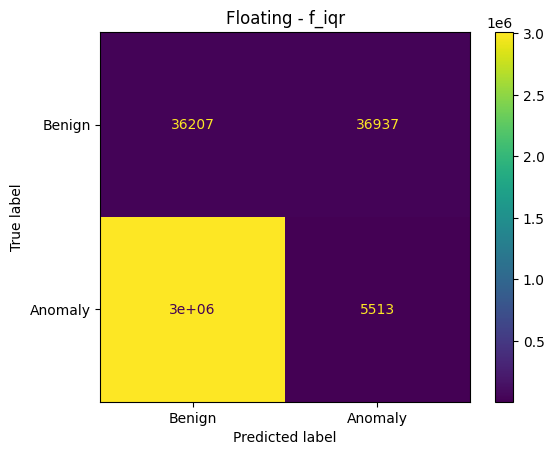

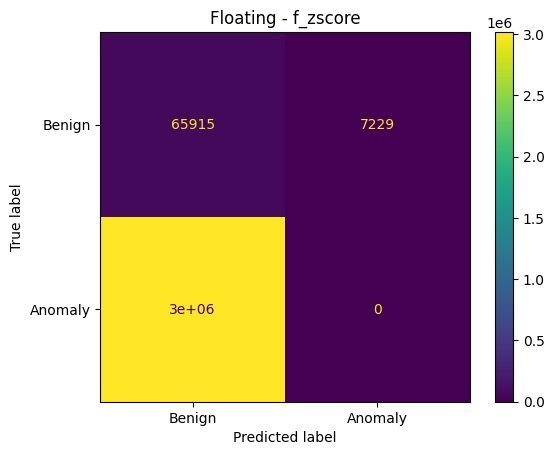

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

for method in methods:
    if method == 'binary':
        for i in threshold:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i].astype(int))
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Binary - {i.strip()}')
            plt.show()
    else:
        for i in threshold_2:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i].astype(int))
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Floating - {i.strip()}')
            plt.show()


### F2-Score

In [25]:
score['F2 Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i].astype(int)).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Binary-{i}: {f2}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i].astype(int)).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Floating-{i}: {f2}')

F2-Binary-b_mean: 0.0
F2-Binary-b_iqr: 0.0
F2-Binary-b_zscore: 0.8527917692156042
F2-Floating-f_mean: 0.0
F2-Floating-f_iqr: 0.002277527344787317
F2-Floating-f_zscore: 0.0


### FPR Score

In [26]:
score['FPR Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i].astype(int)).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Binary-{i}: {fpr}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i].astype(int)).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Floating-{i}: {fpr}')

FPR-Binary-b_mean: 0.0
FPR-Binary-b_iqr: 0.0
FPR-Binary-b_zscore: 0.9999179700317182
FPR-Floating-f_mean: 1.3671661380290934e-05
FPR-Floating-f_iqr: 0.5049901564038062
FPR-Floating-f_zscore: 0.09883244011812316


In [27]:
from sklearn.metrics import accuracy_score

score['Accuracy Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = accuracy_score(df_pred['Label'], df_pred[i].astype(int))
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = accuracy_score(df_pred['Label'], df_pred[i].astype(int))
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Floating-{i}: {acc}')  

Accuracy-Binary-b_mean: 0.02368429658992627
Accuracy-Binary-b_iqr: 0.02368429658992627
Accuracy-Binary-b_zscore: 0.8079122077550335
Accuracy-Floating-f_mean: 0.023683972786243266
Accuracy-Floating-f_iqr: 0.013509089655087556
Accuracy-Floating-f_zscore: 0.021343519765462518


In [28]:
df_score = pd.DataFrame.from_dict(score)
df_score

,Detection Rate,F2 Score,FPR Score,Accuracy Score
b_mean,0.000000,0.000000,0.000000,0.023684
b_iqr,0.000000,0.000000,0.000000,0.023684
b_zscore,0.827509,0.852792,0.999918,0.807912
f_mean,0.000000,0.000000,0.000014,0.023684
f_iqr,0.001828,0.002278,0.504990,0.013509
f_zscore,0.000000,0.000000,0.098832,0.021344


In [29]:
df_score.to_excel('score_ftp_0.0.xlsx')

In [30]:
# %pip install openpyxl